In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
import mplcyberpunk
plt.style.use("cyberpunk")

In [ ]:
embeddings_avg = pd.read_csv('/path/to/embeddings_avg.tsv', sep='\t', header=None)
embeddings_tfidf = pd.read_csv('/path/to/embeddings_tfidf.tsv', sep='\t', header=None)

print(f'Размерность avg embeddings: {embeddings_avg.shape}')
print(f'Размерность tfidf embeddings: {embeddings_tfidf.shape}')

avg_ids = embeddings_avg.iloc[:, 0].values
avg_features = embeddings_avg.iloc[:, 1:].values

tfidf_ids = embeddings_tfidf.iloc[:, 0].values
tfidf_features = embeddings_tfidf.iloc[:, 1:].values

print(f'Количество уникальных ID: {len(set(avg_ids))}')

Размерность avg embeddings: (7601, 201)
Размерность tfidf embeddings: (7601, 201)
Количество уникальных ID: 7601


In [ ]:
def create_label_mapping(data_dir):
    label_mapping = {}
    for class_dir in os.listdir(data_dir):
        if os.path.isdir(os.path.join(data_dir, class_dir)) and class_dir.isdigit():
            class_label = int(class_dir)
            for file in os.listdir(os.path.join(data_dir, class_dir)):
                if file.endswith('.tsv'):
                    file_id = int(file.replace('.tsv', ''))
                    label_mapping[file_id] = class_label
    return label_mapping

train_labels = create_label_mapping('/path/to/annotated-corpus/train/')
test_labels = create_label_mapping('/path/to/annotated-corpus/test/')

y = []
X_avg = []
X_tfidf = []

for i, doc_id in enumerate(avg_ids):
    if doc_id in test_labels:
        y.append(test_labels[doc_id])
        X_avg.append(avg_features[i])
        X_tfidf.append(tfidf_features[i])

X_avg = np.array(X_avg)
X_tfidf = np.array(X_tfidf)
y = np.array(y)

print(f'Размер X_avg: {X_avg.shape}')
print(f'Размер X_tfidf: {X_tfidf.shape}')
print(f'Размер y: {y.shape}')

Размер X_avg: (7600, 200)
Размер X_tfidf: (7600, 200)
Размер y: (7600,)


In [ ]:
def calculate_metrics(y_true, y_pred):
    classes = np.unique(y_true)
    n_classes = len(classes)
    
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for true, pred in zip(y_true, y_pred):
        cm[true-1, pred-1] += 1
    
    precision = np.zeros(n_classes)
    recall = np.zeros(n_classes)
    f1_score = np.zeros(n_classes)
    
    for i in range(n_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        
        if (tp + fp) == 0:
            precision[i] = 0
        else:
            precision[i] = tp / (tp + fp)
        
        if (tp + fn) == 0:
            recall[i] = 0
        else:
            recall[i] = tp / (tp + fn)
        
        if (precision[i] + recall[i]) == 0:
            f1_score[i] = 0
        else:
            f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
    
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    
    precision_macro = np.mean(precision)
    recall_macro = np.mean(recall)
    f1_macro = np.mean(f1_score)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'confusion_matrix': cm
    }

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_avg, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def run_experiment(model, X_train, y_train, X_test, y_test, model_name):
    print(f'Запуск эксперимента: {model_name}')
    
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    
    metrics = calculate_metrics(y_test, y_pred)
    
    print(f'  Accuracy: {metrics["accuracy"]:.4f}')
    print(f'  Macro Precision: {metrics["precision_macro"]:.4f}')
    print(f'  Macro Recall: {metrics["recall_macro"]:.4f}')
    print(f'  Macro F1-Score: {metrics["f1_macro"]:.4f}')
    print(f'  Training Time: {training_time:.4f} seconds')
    print()
    
    return metrics, training_time, y_pred

In [ ]:
svm_linear = SVC(kernel='linear', random_state=42)
metrics_linear, time_linear, _ = run_experiment(svm_linear, X_train_scaled, y_train, X_test_scaled, y_test, 'SVM Linear')

svm_poly = SVC(kernel='poly', degree=3, random_state=42)
metrics_poly, time_poly, _ = run_experiment(svm_poly, X_train_scaled, y_train, X_test_scaled, y_test, 'SVM Polynomial')

svm_rbf = SVC(kernel='rbf', random_state=42)
metrics_rbf, time_rbf, _ = run_experiment(svm_rbf, X_train_scaled, y_train, X_test_scaled, y_test, 'SVM RBF')

svm_sigmoid = SVC(kernel='sigmoid', random_state=42)
metrics_sigmoid, time_sigmoid, _ = run_experiment(svm_sigmoid, X_train_scaled, y_train, X_test_scaled, y_test, 'SVM Sigmoid')

Запуск эксперимента: SVM Linear
  Accuracy: 0.8480
  Macro Precision: 0.8488
  Macro Recall: 0.8480
  Macro F1-Score: 0.8482
  Training Time: 10.0585 seconds

Запуск эксперимента: SVM Polynomial
  Accuracy: 0.8579
  Macro Precision: 0.8598
  Macro Recall: 0.8579
  Macro F1-Score: 0.8584
  Training Time: 2.1853 seconds

Запуск эксперимента: SVM RBF
  Accuracy: 0.8684
  Macro Precision: 0.8685
  Macro Recall: 0.8684
  Macro F1-Score: 0.8683
  Training Time: 1.4924 seconds

Запуск эксперимента: SVM Sigmoid
  Accuracy: 0.8099
  Macro Precision: 0.8088
  Macro Recall: 0.8099
  Macro F1-Score: 0.8090
  Training Time: 1.0699 seconds



In [ ]:
lr = LogisticRegression(random_state=42, max_iter=1000)
metrics_lr, time_lr, _ = run_experiment(lr, X_train_scaled, y_train, X_test_scaled, y_test, 'Logistic Regression')

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42)
metrics_mlp, time_mlp, _ = run_experiment(mlp, X_train_scaled, y_train, X_test_scaled, y_test, 'MLP')

models_comparison = {
    'SVM Linear': (metrics_linear, time_linear),
    'SVM Polynomial': (metrics_poly, time_poly),
    'SVM RBF': (metrics_rbf, time_rbf),
    'SVM Sigmoid': (metrics_sigmoid, time_sigmoid),
    'Logistic Regression': (metrics_lr, time_lr),
    'MLP': (metrics_mlp, time_mlp)
}

Запуск эксперимента: Logistic Regression
  Accuracy: 0.8586
  Macro Precision: 0.8589
  Macro Recall: 0.8586
  Macro F1-Score: 0.8586
  Training Time: 2.9851 seconds

Запуск эксперимента: MLP
  Accuracy: 0.8638
  Macro Precision: 0.8647
  Macro Recall: 0.8638
  Macro F1-Score: 0.8641
  Training Time: 4.2043 seconds



In [9]:
epochs_list = [50, 100, 200, 300, 500]
epochs_results = []

for epochs in epochs_list:
    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=epochs, random_state=42)
    metrics, train_time, _ = run_experiment(mlp, X_train_scaled, y_train, X_test_scaled, y_test, f'MLP {epochs} epochs')
    epochs_results.append((epochs, metrics, train_time))

Запуск эксперимента: MLP 50 epochs
  Accuracy: 0.8671
  Macro Precision: 0.8681
  Macro Recall: 0.8671
  Macro F1-Score: 0.8674
  Training Time: 1.8836 seconds

Запуск эксперимента: MLP 100 epochs
  Accuracy: 0.8638
  Macro Precision: 0.8647
  Macro Recall: 0.8638
  Macro F1-Score: 0.8641
  Training Time: 4.0492 seconds

Запуск эксперимента: MLP 200 epochs
  Accuracy: 0.8651
  Macro Precision: 0.8658
  Macro Recall: 0.8651
  Macro F1-Score: 0.8654
  Training Time: 4.7283 seconds

Запуск эксперимента: MLP 300 epochs
  Accuracy: 0.8651
  Macro Precision: 0.8658
  Macro Recall: 0.8651
  Macro F1-Score: 0.8654
  Training Time: 4.6174 seconds

Запуск эксперимента: MLP 500 epochs
  Accuracy: 0.8651
  Macro Precision: 0.8658
  Macro Recall: 0.8651
  Macro F1-Score: 0.8654
  Training Time: 4.6278 seconds



In [10]:
pca_dims = [50, 100, 150]
pca_results = []

for n_components in pca_dims:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    svm_linear = SVC(kernel='linear', random_state=42)
    metrics, train_time, _ = run_experiment(svm_linear, X_train_pca, y_train, X_test_pca, y_test, f'SVM Linear with PCA {n_components}')
    pca_results.append((n_components, metrics, train_time))

Запуск эксперимента: SVM Linear with PCA 50
  Accuracy: 0.8605
  Macro Precision: 0.8605
  Macro Recall: 0.8605
  Macro F1-Score: 0.8604
  Training Time: 3.1153 seconds

Запуск эксперимента: SVM Linear with PCA 100
  Accuracy: 0.8539
  Macro Precision: 0.8540
  Macro Recall: 0.8539
  Macro F1-Score: 0.8540
  Training Time: 6.0421 seconds

Запуск эксперимента: SVM Linear with PCA 150
  Accuracy: 0.8572
  Macro Precision: 0.8570
  Macro Recall: 0.8572
  Macro F1-Score: 0.8571
  Training Time: 9.2658 seconds



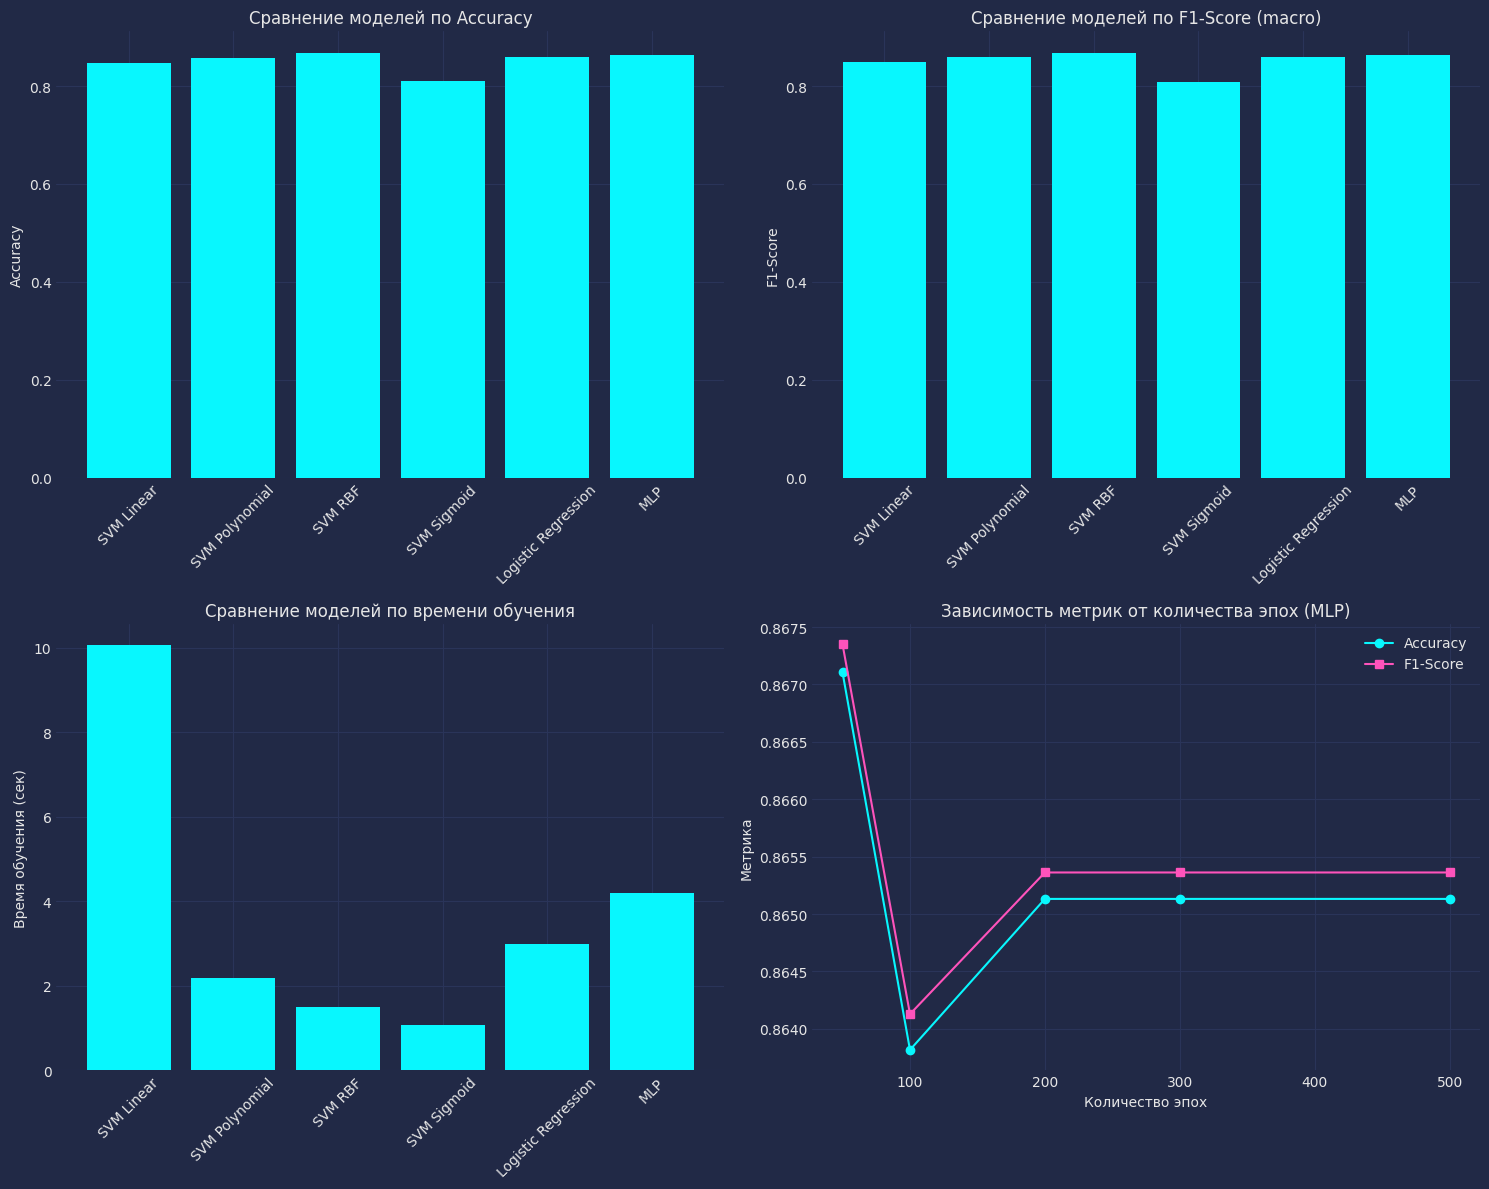

In [ ]:
model_names = list(models_comparison.keys())
accuracies = [models_comparison[name][0]['accuracy'] for name in model_names]
f1_scores = [models_comparison[name][0]['f1_macro'] for name in model_names]
train_times = [models_comparison[name][1] for name in model_names]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].bar(model_names, accuracies)
axes[0, 0].set_title('Сравнение моделей по Accuracy')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].bar(model_names, f1_scores)
axes[0, 1].set_title('Сравнение моделей по F1-Score (macro)')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].bar(model_names, train_times)
axes[1, 0].set_title('Сравнение моделей по времени обучения')
axes[1, 0].set_ylabel('Время обучения (сек)')
axes[1, 0].tick_params(axis='x', rotation=45)

epochs_vals = [x[0] for x in epochs_results]
epochs_acc = [x[1]['accuracy'] for x in epochs_results]
epochs_f1 = [x[1]['f1_macro'] for x in epochs_results]

axes[1, 1].plot(epochs_vals, epochs_acc, label='Accuracy', marker='o')
axes[1, 1].plot(epochs_vals, epochs_f1, label='F1-Score', marker='s')
axes[1, 1].set_title('Зависимость метрик от количества эпох (MLP)')
axes[1, 1].set_xlabel('Количество эпох')
axes[1, 1].set_ylabel('Метрика')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

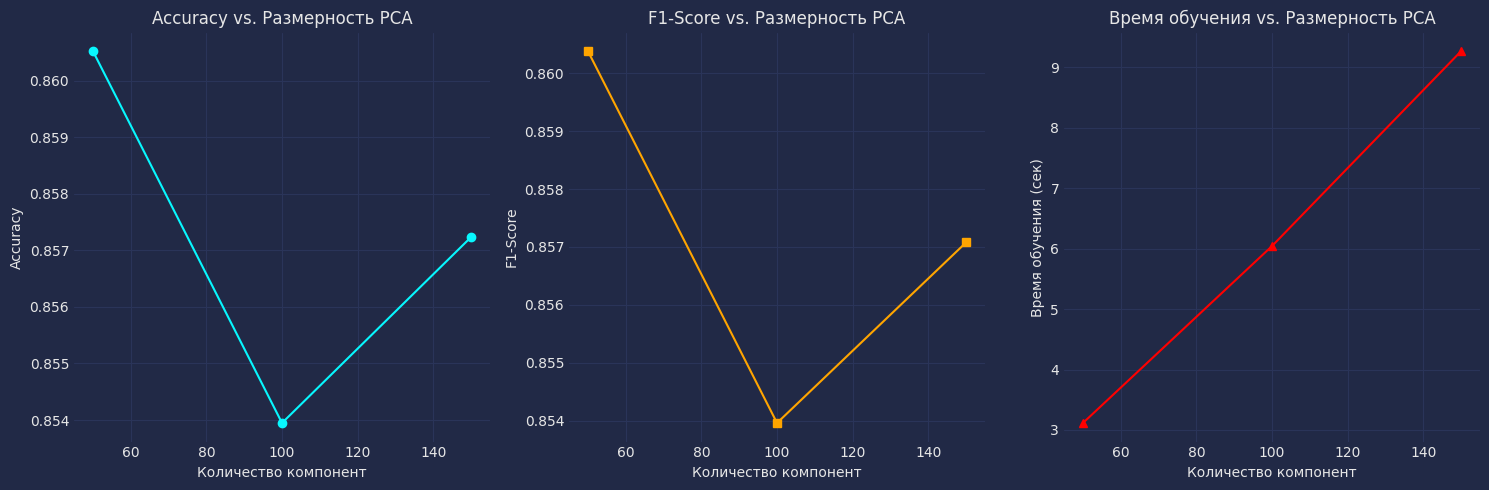

In [ ]:
pca_dims = [x[0] for x in pca_results]
pca_acc = [x[1]['accuracy'] for x in pca_results]
pca_f1 = [x[1]['f1_macro'] for x in pca_results]
pca_times = [x[2] for x in pca_results]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(pca_dims, pca_acc, marker='o')
axes[0].set_title('Accuracy vs. Размерность PCA')
axes[0].set_xlabel('Количество компонент')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True)

axes[1].plot(pca_dims, pca_f1, marker='s', color='orange')
axes[1].set_title('F1-Score vs. Размерность PCA')
axes[1].set_xlabel('Количество компонент')
axes[1].set_ylabel('F1-Score')
axes[1].grid(True)

axes[2].plot(pca_dims, pca_times, marker='^', color='red')
axes[2].set_title('Время обучения vs. Размерность PCA')
axes[2].set_xlabel('Количество компонент')
axes[2].set_ylabel('Время обучения (сек)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
best_model_name = max(models_comparison, key=lambda x: models_comparison[x][0]['f1_macro'])
best_metrics, best_time = models_comparison[best_model_name]

print(f'Лучшая модель: {best_model_name}')
print(f'Accuracy: {best_metrics["accuracy"]:.4f}')
print(f'F1-Score (macro): {best_metrics["f1_macro"]:.4f}')
print(f'Время обучения: {best_time:.4f} секунд')
print(f'Precision по классам: {best_metrics["precision"]}')
print(f'Recall по классам: {best_metrics["recall"]}')
print(f'F1-Score по классам: {best_metrics["f1_score"]}')

best_epoch_idx = max(range(len(epochs_results)), key=lambda i: epochs_results[i][1]['f1_macro'])
best_epoch, best_epoch_metrics, best_epoch_time = epochs_results[best_epoch_idx]

print(f'\nОптимальное количество эпох для MLP: {best_epoch}')
print(f'Accuracy: {best_epoch_metrics["accuracy"]:.4f}')
print(f'F1-Score (macro): {best_epoch_metrics["f1_macro"]:.4f}')

best_pca_idx = max(range(len(pca_results)), key=lambda i: pca_results[i][1]['f1_macro'])
best_pca_dim, best_pca_metrics, best_pca_time = pca_results[best_pca_idx]

print(f'\nОптимальная размерность PCA: {best_pca_dim}')
print(f'Accuracy: {best_pca_metrics["accuracy"]:.4f}')
print(f'F1-Score (macro): {best_pca_metrics["f1_macro"]:.4f}')

Лучшая модель: SVM RBF
Accuracy: 0.8684
F1-Score (macro): 0.8683
Время обучения: 1.4924 секунд
Precision по классам: [0.88797814 0.93041237 0.82077922 0.83464567]
Recall по классам: [0.85526316 0.95       0.83157895 0.83684211]
F1-Score по классам: [0.87131367 0.94010417 0.82614379 0.83574244]

Оптимальное количество эпох для MLP: 50
Accuracy: 0.8671
F1-Score (macro): 0.8674

Оптимальная размерность PCA: 50
Accuracy: 0.8605
F1-Score (macro): 0.8604


Отброшено 10.0% признаков:
  Accuracy: 0.8625
  F1-Score (macro): 0.8624
  Время обучения: 1.5696 секунд
Отброшено 20.0% признаков:
  Accuracy: 0.8586
  F1-Score (macro): 0.8583
  Время обучения: 1.2111 секунд
Отброшено 30.0% признаков:
  Accuracy: 0.8566
  F1-Score (macro): 0.8564
  Время обучения: 1.3832 секунд
Отброшено 40.0% признаков:
  Accuracy: 0.8592
  F1-Score (macro): 0.8591
  Время обучения: 1.0892 секунд
Отброшено 50.0% признаков:
  Accuracy: 0.8605
  F1-Score (macro): 0.8604
  Время обучения: 1.0609 секунд


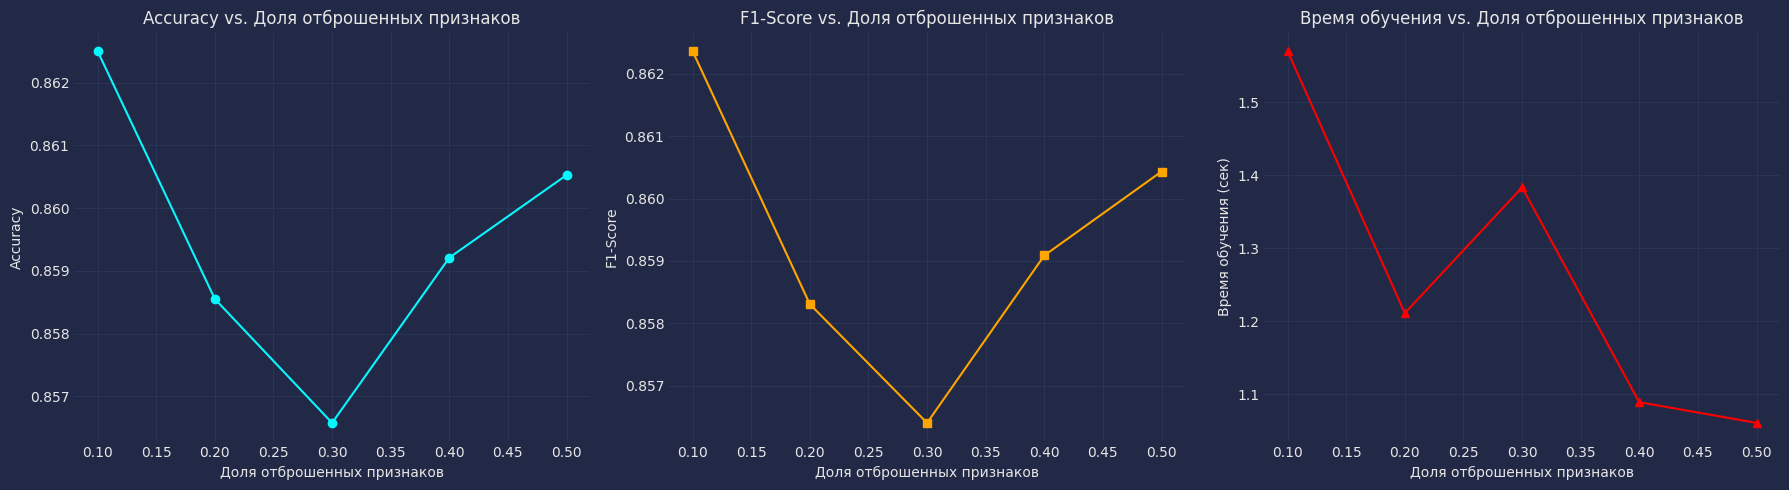

In [ ]:
drop_ratios = [0.1, 0.2, 0.3, 0.4, 0.5]
drop_results = []

for drop_ratio in drop_ratios:
    n_features = X_train_scaled.shape[1]
    n_drop = int(n_features * drop_ratio)

    drop_indices = np.random.choice(n_features, size=n_drop, replace=False)
    keep_indices = np.setdiff1d(np.arange(n_features), drop_indices)

    X_train_dropped = X_train_scaled[:, keep_indices]
    X_test_dropped = X_test_scaled[:, keep_indices]

    svm_linear = SVC(kernel='rbf', random_state=42)
    start_time = time.time()
    svm_linear.fit(X_train_dropped, y_train)
    train_time = time.time() - start_time
    y_pred = svm_linear.predict(X_test_dropped)

    metrics = calculate_metrics(y_test, y_pred)

    print(f'Отброшено {drop_ratio*100}% признаков:')
    print(f'  Accuracy: {metrics["accuracy"]:.4f}')
    print(f'  F1-Score (macro): {metrics["f1_macro"]:.4f}')
    print(f'  Время обучения: {train_time:.4f} секунд')

    drop_results.append((drop_ratio, metrics, train_time))

drop_ratios_plot = [x[0] for x in drop_results]
drop_acc = [x[1]['accuracy'] for x in drop_results]
drop_f1 = [x[1]['f1_macro'] for x in drop_results]
drop_times = [x[2] for x in drop_results]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(drop_ratios_plot, drop_acc, marker='o')
axes[0].set_title('Accuracy vs. Доля отброшенных признаков')
axes[0].set_xlabel('Доля отброшенных признаков')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True)

axes[1].plot(drop_ratios_plot, drop_f1, marker='s', color='orange')
axes[1].set_title('F1-Score vs. Доля отброшенных признаков')
axes[1].set_xlabel('Доля отброшенных признаков')
axes[1].set_ylabel('F1-Score')
axes[1].grid(True)

axes[2].plot(drop_ratios_plot, drop_times, marker='^', color='red')
axes[2].set_title('Время обучения vs. Доля отброшенных признаков')
axes[2].set_xlabel('Доля отброшенных признаков')
axes[2].set_ylabel('Время обучения (сек)')
axes[2].grid(True)

plt.tight_layout()
plt.show()